## <center>News articles classification 

The data set used in this reseach can be taken on Kaggle.com: https://www.kaggle.com/yutkin/corpus-of-russian-news-articles-from-lenta.

The news articles represented in the data set belong to several topics, so we have a multiclass classification task. In this research I build Naive Bayes and Linear Support Vector Machine models and decide which one has better performance for this task.


The preprocessing pipeline is:
* lowercase and tokenize text
* remove stopwords
* lemmatization.

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import requests
import gensim
import pymorphy2
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV 

## Exploratory data analysis

In [2]:
df = pd.read_csv('lenta-ru-news.csv', dtype=str)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800975 entries, 0 to 800974
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     800975 non-null  object
 1   title   800975 non-null  object
 2   text    800970 non-null  object
 3   topic   738973 non-null  object
 4   tags    773756 non-null  object
 5   date    800975 non-null  object
dtypes: object(6)
memory usage: 36.7+ MB


In [4]:
df.dropna(subset=['text'], i\lace=True)
df.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


In [6]:
# Let's count the length of text and the number of words for each text 
df['text_len'] = df['text'].apply(len)
df['text_word_count'] = df['text'].apply(lambda x: len(x.split()))

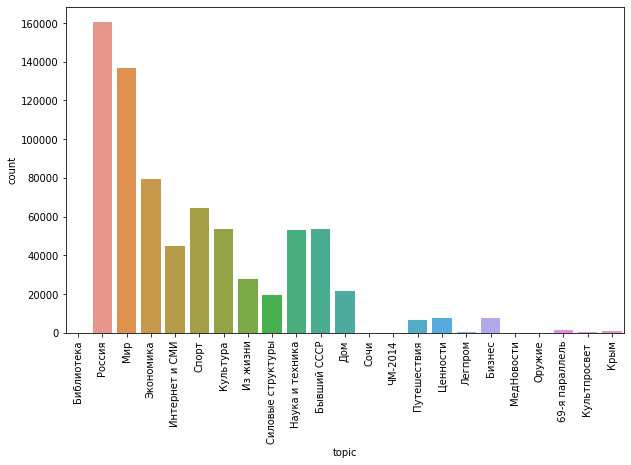

In [7]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(df['topic'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

As we can see the most popular topic is "Россия". It is highly imbalanced feature.

In [8]:
df['text_word_count'].describe()

count    800970.000000
mean        180.300120
std          73.707738
min           1.000000
25%         133.000000
50%         170.000000
75%         216.000000
max        8092.000000
Name: text_word_count, dtype: float64

In average the count of words in texts is 180. Most of the news one can read less than for 1 minute. That's good! People don't like reading a long text.<br>
Also we can see that maximum count of words is over 8000. That's a lot! In the other hand minimum count is only 1. Let's explore outliers a little more. 

In [9]:
df.loc[df['text_word_count']==1]

,url,title,text,topic,tags,date,text_len,text_word_count
46631,https://lenta.ru/news/2002/03/29/copy/,Американские конгрессмены пытаются ускорить пр...,Wired,Интернет и СМИ,Все,2002/03/29,5,1
79663,https://lenta.ru/news/2003/10/09/aeroport/,Шереметьево будут управлять авиаторы,"""Ведомости""",Экономика,Все,2003/10/09,11,1
82684,https://lenta.ru/news/2003/11/25/concorde/,"Новый франко-японский ""Конкорд"" будет летать в...",EADS,Мир,Все,2003/11/25,4,1
92826,https://lenta.ru/news/2004/05/06/teddybear/,Португалец закрыл аэропорт при помощи плюшевог...,Telegraph,Из жизни,Все,2004/05/06,9,1
92878,https://lenta.ru/news/2004/05/07/rockets/,На украинских артиллерийских складах огонь под...,ИТАР-ТАСС,Мир,Все,2004/05/07,9,1
...,...,...,...,...,...,...,...,...
251577,https://lenta.ru/news/2008/10/22/art/,Джордж Майкл откроет новую художественную галерею,M&C,Культура,Все,2008/10/22,3,1
252892,https://lenta.ru/news/2008/10/31/vampires/,Ученые проследили эволюцию вампиров,Naturwissenschaften,Наука и техника,Все,2008/10/31,19,1
253967,https://lenta.ru/news/2008/11/07/plastictube/,Пластиковые пробирки портят результаты опытов,Science,Наука и техника,Все,2008/11/07,7,1
256352,https://lenta.ru/news/2008/11/24/plasmasound/,Физики узнали как звучал Большой Взрыв,работу,Наука и техника,Все,2008/11/24,6,1


During my investigation I found out that there are plenty of samples in the dataset that contain not full text of topics but just few first words of them. Probably it's data scrapping error. 

In [10]:
df.sort_values('text_word_count', ascending=False).head()

,url,title,text,topic,tags,date,text_len,text_word_count
84234,https://lenta.ru/news/2003/12/18/president/,Пресс-конференция Владимира Путина. Интернет-т...,18 декабря в 12:00 началась традиционная всеро...,Россия,Все,2003/12/18,55387,8092
108990,https://lenta.ru/news/2004/12/23/putin1/,Ежегодная пресс-конференция Владимира Путина,"Добрый день, уважаемые коллеги. Сегодняшнюю вс...",Россия,Все,2004/12/23,24566,3578
294877,https://lenta.ru/news/2009/08/13/border/,Россия назвала условия пропуска грузов из Литвы,"Представители руководства России и Литвы, кото...",Бывший СССР,Все,2009/08/13,20090,2662
296495,https://lenta.ru/news/2009/08/27/explain/,Кокойты отказал строителям газопровода в освоб...,Президент Южной Осетии Эдуард Кокойты прокомме...,Бывший СССР,Все,2009/08/27,17642,2306
307908,https://lenta.ru/news/2009/11/18/prosecutor/,Акаеву гарантировали свободу в случае возвраще...,Бывший президент Киргизии Аскар Акаев не будет...,Бывший СССР,Все,2009/11/18,13934,1954


It's only one huge topic that consists the press conference with Vladimir Putin in 2003 year. 

Let's plot distribution for word counts that are beyond 99th percentile. 

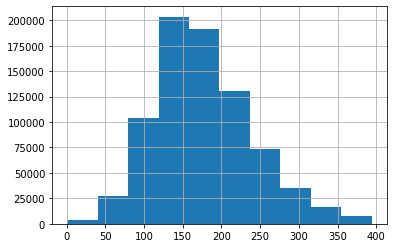

In [11]:
text_word_count = df.loc[df['text_word_count'] < df['text_word_count'].quantile(.99), 'text_word_count']
text_word_count.hist();

So 99% of texts are shorter than 400 words and most of them are about 150 words long. 

Let's check if the destribution of the feature is normal. We'll use qqplot and normal test from statsmodels package for this.

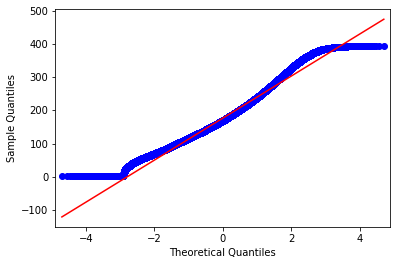

In [12]:
from statsmodels.graphics.gofplots import qqplot
qqplot(text_word_count, line='s')
plt.show()

qqplot shows that the samples deviate from normal. Double check: 

In [14]:
from scipy.stats import normaltest
stat, p = normaltest(text_word_count)
alpha = 1e-3
print(f"p = {p}")
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected. Not normal!")
else:
    print("The null hypothesis cannot be rejected. It's normal")

p = 0.0
The null hypothesis can be rejected. Not normal!


<br>Let's see which yeas was the most productive for Lenta.ru

In [15]:
df['date'].apply(lambda x: x[:4]).value_counts()

2016    63107
2019    59729
2017    58792
2009    51343
2008    50389
2012    46047
2011    44822
2015    44766
2010    44587
2018    43951
2013    43297
2014    38075
2007    36029
2006    35960
2005    30718
2004    24386
2002    22179
2001    21974
2003    21557
2000    16176
1999     3081
1914        5
Name: date, dtype: int64

2016 was rich for news.

## Modeling 

Before exctracting the most valuable data from the text let's do some preprocessing:
1. We use gensim.utils.simple_preprocess to lowercase and tokenize text. This awesome function remove punctuation and tokens shorter than 2 charecters by default.
2. We get rid of the stopwords.
3. We use pymorphy2 for lemmatization.

In [5]:
url_stopwords_ru = "https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.txt"
r = requests.get(url_stopwords_ru)
if r.ok:
    stop_words = r.text.splitlines()
else: # short list of stop words from nltk
    from nltk.corpus import stopwords
    stop_words = stopwords.words("russian")  
stop_words = stop_words + ['сообщать', 'сообщает', 'сообщил','заявил', 'подчеркнул', 'напомним'] # these words appear in almost every news

In [17]:
data = df['text'].apply(gensim.utils.simple_preprocess)

CPU times: user 2min 44s, sys: 2.82 s, total: 2min 47s
Wall time: 2min 47s


In [51]:
%%time
morph = pymorphy2.MorphAnalyzer()
data = data.apply(lambda text: [morph.parse(word)[0].normal_form for word in text])

In [7]:
data = data.apply(lambda text: [word for word in text if word not in stop_words and len(word) > 2])

In [9]:
print("Original news text: ")
print(df['text'][555])

print("Preprocessed text: ")
print(' '.join(data[555]))

Original news text: 
Как сообщает ИТАР-ТАСС, невероятный хаос вызвало в среду в Лондоне одновременноезакрытие девяти станций метро. Станции были закрыты из-за неполадок в системах эскалаторов, которые неожиданное начали останавливаться. Эти остановки оцениваются как одни из наиболее опасных инцидентов в работе метрополитена. Полностью парализованной оказалась самая загруженная - северная - ветка лондонского метро, которым ежедневно пользуются более полумиллиона пассажиров. Инженерные службы в срочном порядке выявляют причину многочисленных аварий и заменяют поврежденные сигнальные кабели. Не исключается возможность саботажа. С перебоями работают также и станции в самом центре Лондона, где скапливаются  огромные толпы народа. Лондонское метро, являющееся одним из старейших в мире, в основном, было построено  в конце прошлого и начале нынешнего века. Возможно, оно уже просто не может удовлетворять  потребности столица Великобритании.
Preprocessed text: 
итар тасс невероятный хаос вызвать

<br>Now let's exctract the most valuable data from the text. The logic says the most frequent words are the most valuable. One way to count words is to use the CountVectorizer. Let's count not only individual words but their bigrams. 

In [12]:
vec = CountVectorizer(ngram_range=(1,2))
bag_of_words = vec.fit_transform(data.apply(' '.join))
print('The shape of final matrix is ', bag_of_words.shape)

The shape of final matrix is  (800970, 21213621)


In [13]:
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq[:10]

[('россия', 450048),
 ('заявить', 341655),
 ('компания', 331034),
 ('российский', 310669),
 ('президент', 293928),
 ('слово', 289348),
 ('страна', 287987),
 ('один', 249020),
 ('доллар', 244874),
 ('сша', 241036)]

As expected Lenta.ru news are mostly about Russia and politics. Another very popular theme is the USA of course. <br> 
Let's take a look at what are 10 most relevant words for a random partucular text.   

In [24]:
feature_names = np.array(vec.get_feature_names())

In [412]:
feature_names[np.argsort(-(bag_of_words[10000].toarray().ravel()))[:10]]

array(['вагон', 'метро', 'поворот', 'начинаться реализация', 'икарус',
       'вид', 'появиться', 'подвижный состав', 'новый',
       'мытищинский завод'], dtype='<U37')

The title for this article could be somithing like "Мытищинский завод выпустит новые вагоны метро" ("Mytishchi Machine-Building Plant is releasing new subway cars"). Let's check!

In [26]:
df.title[10000] 

'Вагоны московского метро будут складываться гармошкой'

Which means "Moscow subway cars will be folded like an accordion". Well, we were close enough!

Now let's train a model to classify text to particular topics. There are 23 topics in the dataset which means we have multiclass problem. There are several supervized algorithms we can use to solve this type of problem. We'll try:
* Naive Bayes
* Linear Support Vector Machine

Since we have imbalanced classes we'll use precision, recall and F1 score as metrics to evaluate classifiers output quality.<br> 
There are over 62K samples with missing values in 'topic' feature. We'll remove them from the dataset because we can't train or estimate the quality without targets. After that we split data to train and test datasets and apply TfidfTransformer to raw text to a matrix of TF-IDF features.

In [9]:
# undefined topic
natopic_idx = df.loc[df['topic'].isna()].index
data.drop(natopic_idx, axis=0, inplace = True)
df.drop(natopic_idx, axis=0, inplace = True)

In [20]:
print('The number of topics is: ', len(df['topic'].unique()))

The number of topics is:  23


In [11]:
X_train, X_test, y_train, y_test = train_test_split(data.apply(' '.join), df['topic'], random_state = 5)
count_vec = CountVectorizer(ngram_range=(1,2))
X_train_count = count_vec.fit_transform(X_train)
X_test_count = count_vec.transform(X_test)
tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_count)
X_test_tfidf = tfidf.transform(X_test_count)

<b>Naive Bayes Classifier</b>

In [13]:
%%time
clf = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

CPU times: user 16.9 s, sys: 24.3 s, total: 41.2 s
Wall time: 57.6 s


In [15]:
prf = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print(f'Naive Bayes classifier\n\t Precision: {prf[0]}, Recall: {prf[1]}, F1 score: {prf[2]}')

Naive Bayes classifier
 Precision: 0.7416486807261115, Recall: 0.6611490619350229, F1 score: 0.6150456049676254


<b>Linear Support Vector Machine</b>

In [11]:
clf = LinearSVC().fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

In [12]:
prf = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print(f'Linear Support Vector Machine\n\t Precision: {prf[0]}, Recall: {prf[1]}, F1 score: {prf[2]}')

Linear Support Vector Machine
	 Precision: 0.8658727431635238, Recall: 0.8671173853265636, F1 score: 0.8653219405150376


/home/yulits/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM shows much better result than Naive Bayes: F1 score 0.87 vs 0.62. But it's how the out-of-box models worked.<br> 
Let's tune the hyperparameters.

In [12]:
param_grid = {'alpha': [1, 0.5, 0.1, 10e-2, 10e-3, 10e-4, 10e-5]}
clf = GridSearchCV(MultinomialNB(), param_grid, cv=3, scoring='f1_weighted')
clf.fit(X_train_tfidf, y_train)
print(clf.best_estimator_) 
print(clf.best_score_)

/home/yulits/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


MultinomialNB(alpha=0.0001, class_prior=None, fit_prior=True)
0.818026848629199


In [13]:
y_pred = clf.best_estimator_.predict(X_test_tfidf)
prf = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print(f'Naive Bayes classifier\n\t Precision: {prf[0]}, Recall: {prf[1]}, F1 score: {prf[2]}')

Naive Bayes classifier
	 Precision: 0.8346974431630445, Recall: 0.8360091370668283, F1 score: 0.8338307314771222


/home/yulits/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


After tuning Naive Bayes gave us F1 score 0.83. Much better but still worse than Linear SVM.<br><b>Linear SVM with F1 score 0.87 is the winner!</b> Maybe it can give even better result after tuning. BUT actually Naive Bayes is much faster!  